In [1]:
from functions.data_functions import save_pickle, load_pickle, load_data
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')
import arviz as az

In [2]:
models_summary = load_pickle('saved_models')
fitted_models = load_pickle('fitted_models')
pca_df = load_data('BEACON', 'pca_df')

In [3]:
comp = ['comp_1', 'comp_2','comp_3']
variables = ['Intercept', 'group', 'variable', 'group:variable']

In [4]:
az.summary(fitted_models['alt']['comp_1'], var_names=variables, kind='stats')

,mean,sd,hdi_3%,hdi_97%
Intercept,1.066,0.190,0.710,1.422
group[HC],-3.556,0.347,-4.221,-2.911
variable[t2],-0.274,0.187,-0.618,0.078
"group:variable[HC, t2]",0.920,0.343,0.275,1.558


In [5]:
az.summary(fitted_models['alt']['comp_2'], var_names=variables, kind='stats')

,mean,sd,hdi_3%,hdi_97%
Intercept,-0.008,0.106,-0.206,0.192
group[HC],0.031,0.193,-0.335,0.391
variable[t2],0.080,0.110,-0.127,0.287
"group:variable[HC, t2]",-0.268,0.202,-0.630,0.128


In [6]:
az.summary(fitted_models['alt']['comp_3'], var_names=variables, kind='stats')

,mean,sd,hdi_3%,hdi_97%
Intercept,-0.201,0.090,-0.378,-0.038
group[HC],0.679,0.166,0.373,0.996
variable[t2],-0.045,0.084,-0.199,0.117
"group:variable[HC, t2]",0.150,0.153,-0.147,0.432


                    rank    elpd_loo       p_loo  elpd_diff    weight  \
alternative_comp_1     0 -500.092148  128.545324   0.000000  0.917566   
null_comp_1            1 -520.197004  116.016257  20.104857  0.082434   

                           se       dse  warning scale  
alternative_comp_1  11.835803  0.000000     True   log  
null_comp_1         10.640802  6.717531     True   log  
                    rank    elpd_loo       p_loo  elpd_diff        weight  \
null_comp_2            0 -355.524017  101.551444   0.000000  1.000000e+00   
alternative_comp_2     1 -357.018033  100.378544   1.494016  3.330669e-16   

                           se       dse  warning scale  
null_comp_2         14.625501  0.000000     True   log  
alternative_comp_2  14.827355  1.519813     True   log  
                    rank    elpd_loo       p_loo  elpd_diff    weight  \
null_comp_3            0 -292.310315  112.350028   0.000000  0.549817   
alternative_comp_3     1 -292.767542  107.298083   0.457227 

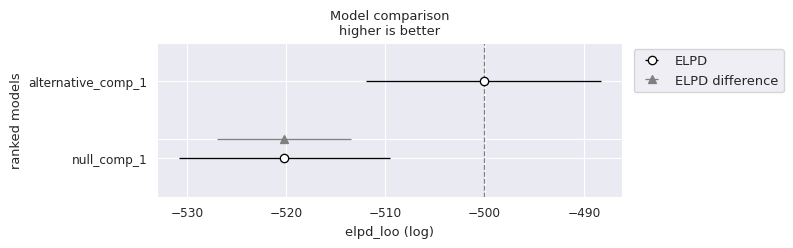

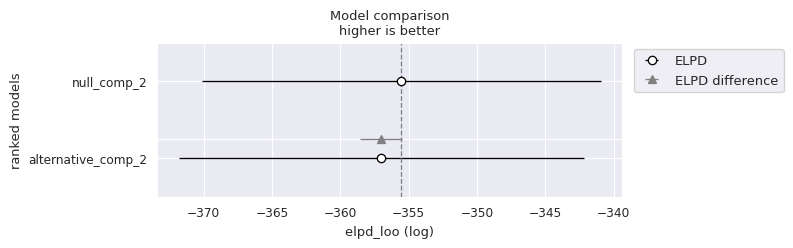

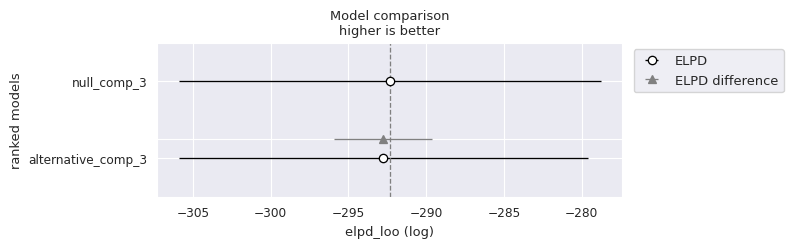

In [7]:
for component in comp:
    az_comparison = az.compare({f'null_{component}' : fitted_models['null'][component], f'alternative_{component}': fitted_models['alt'][component]})
    print(az_comparison)
    az.plot_compare(az_comparison)

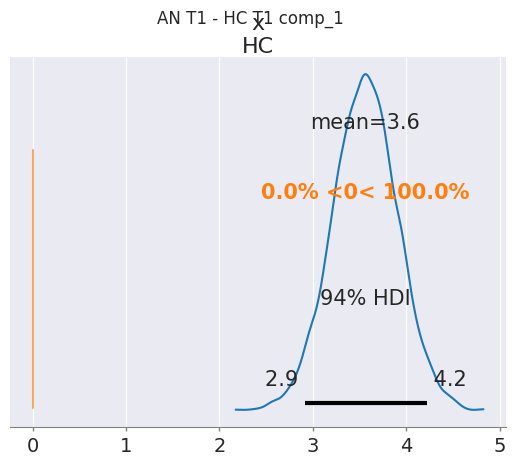

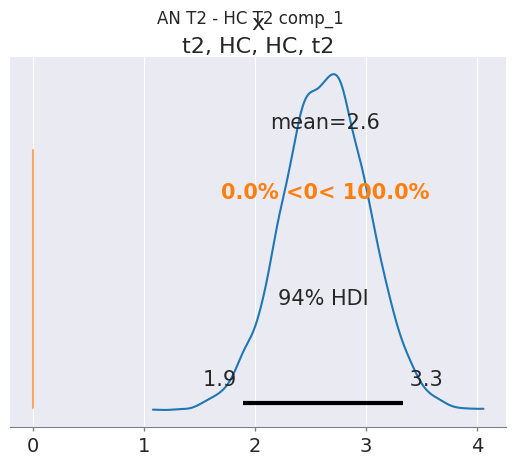

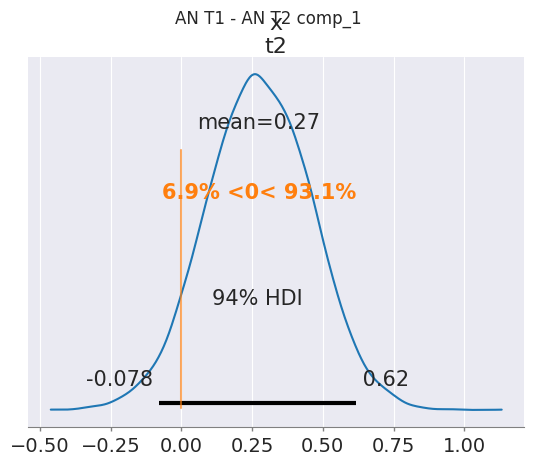

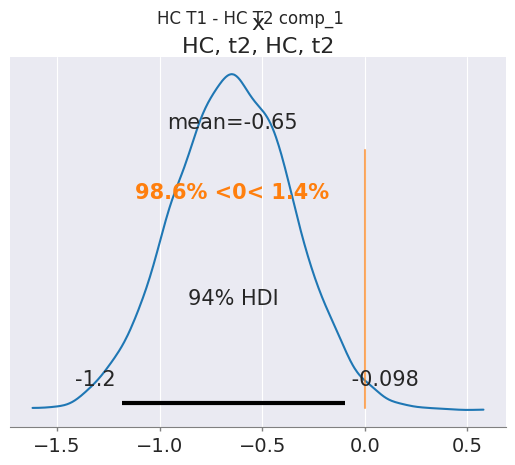

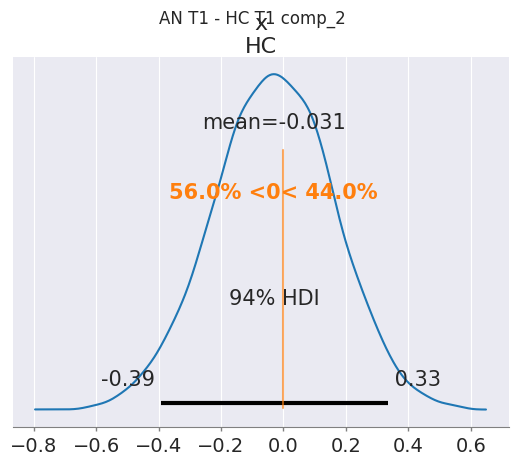

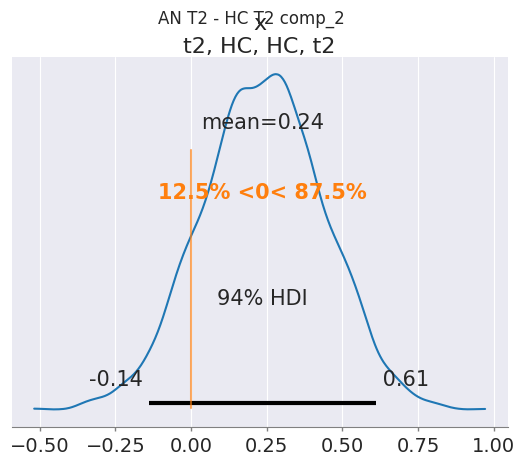

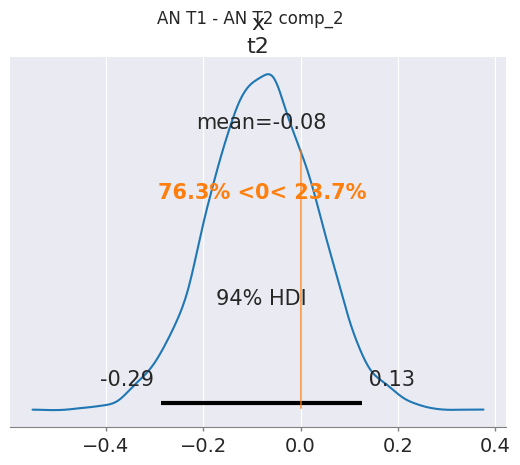

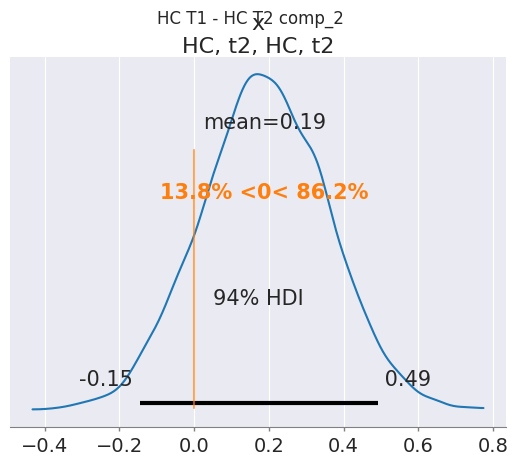

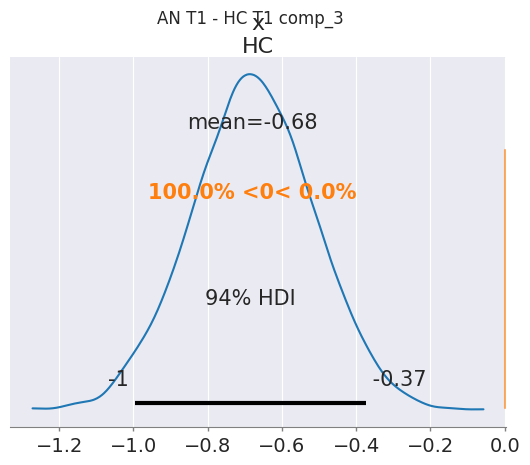

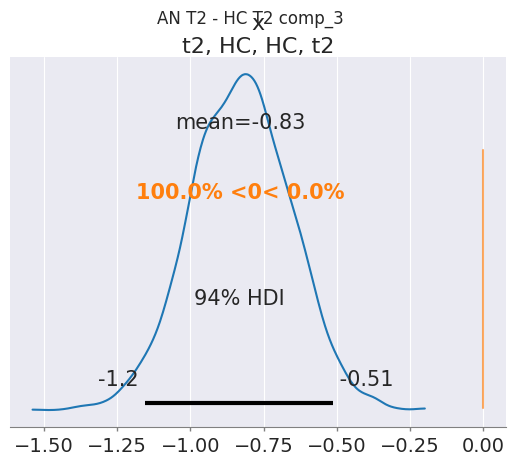

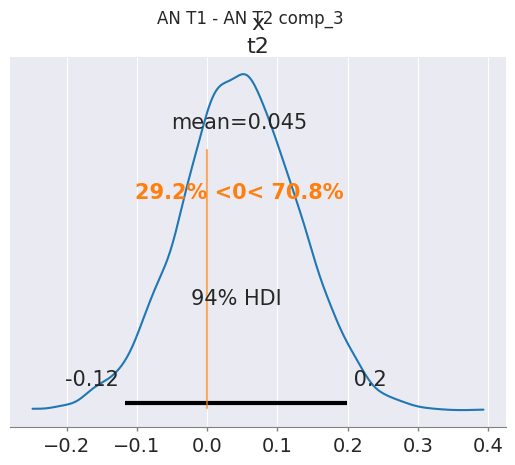

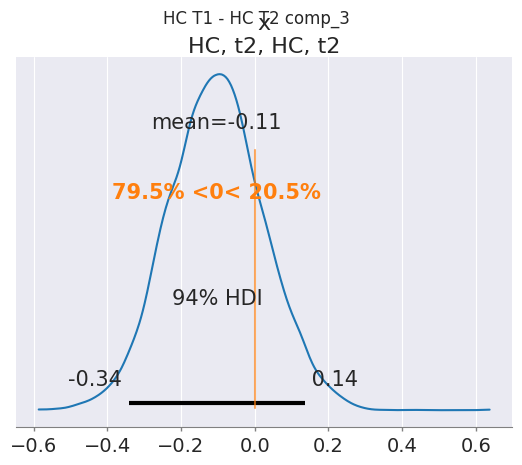

In [12]:
pred_summary = {
   'comp_1': {},
   'comp_2': {},
   'comp_3': {},
}

for component in comp:
   an_t1 = fitted_models['alt'][component].posterior["Intercept"]
   hc_t1 = fitted_models['alt'][component].posterior["Intercept"] + fitted_models['alt'][component].posterior["group"]
   an_t2 = fitted_models['alt'][component].posterior["Intercept"] + fitted_models['alt'][component].posterior["variable"]
   hc_t2 = fitted_models['alt'][component].posterior["Intercept"] +  fitted_models['alt'][component].posterior["variable"] + fitted_models['alt'][component].posterior["group"] +  fitted_models['alt'][component].posterior["group:variable"]
   
   pred_summary[component]['an_t1'] = az.summary(an_t1, kind='stats')
   pred_summary[component]['hc_t1'] = az.summary(hc_t1, kind='stats')
   pred_summary[component]['an_t2'] = az.summary(an_t2, kind='stats')
   pred_summary[component]['hc_t2'] = az.summary(hc_t2, kind='stats')

   diff_t1 = an_t1 - hc_t1
   diff_t2 = an_t2 - hc_t2
   diff_an = an_t1 - an_t2
   diff_hc = hc_t1 - hc_t2

   ax_1 = az.plot_posterior(diff_t1, ref_val=0)
   fig_1 = ax_1.get_figure()
   fig_1.suptitle(f'AN T1 - HC T1 {component}')
   ax_2 = az.plot_posterior(diff_t2, ref_val=0)
   fig_2 = ax_2.get_figure()
   fig_2.suptitle(f'AN T2 - HC T2 {component}')
   ax_3 = az.plot_posterior(diff_an, ref_val=0)
   fig_3 = ax_3.get_figure()
   fig_3.suptitle(f'AN T1 - AN T2 {component}')
   ax_4 = az.plot_posterior(diff_hc, ref_val=0)
   fig_4 = ax_4.get_figure()
   fig_4.suptitle(f'HC T1 - HC T2 {component}')

In [15]:
for component in comp:
    print(component)
    print(pred_summary[component]['an_t1'],'\n' , '-' *10)

comp_1
            mean    sd  hdi_3%  hdi_97%
Intercept  1.066  0.19    0.71    1.422 ----------
comp_2
            mean     sd  hdi_3%  hdi_97%
Intercept -0.008  0.106  -0.206    0.192 ----------
comp_3
            mean    sd  hdi_3%  hdi_97%
Intercept -0.201  0.09  -0.378   -0.038 ----------


In [ ]:
dfs = {}

for component in comp:
    comp_df = pca_df[['G_Number', 
           f'{component}_t2', f'{component}_t1','group', 
           ]].rename(columns={f'{component}_t1':'t1', f'{component}_t2':'t2', 'G_Number':'participants'})
           
    comp_df['id'] = comp_df.index
    comp_df = pd.melt(comp_df, value_vars=['t2','t1'], id_vars='participants').sort_values(by=['participants'], ascending=True).reset_index(drop=True)
    comp_df['group'] = comp_df['participants'].apply(lambda group: 'HC' if 'G1' in group else 'AN')

    dfs[component] = comp_df

In [ ]:
dfs['comp_1']

,participants,variable,value,group
0,G1002,t1,-3.081270,HC
1,G1002,t2,-3.409618,HC
2,G1004,t1,-2.366142,HC
3,G1004,t2,2.175929,HC
4,G1006,t1,-3.268447,HC
...,...,...,...,...
263,G2140,t2,3.998414,AN
264,G2141,t1,2.462581,AN
265,G2141,t2,2.025310,AN
266,G2142,t2,-0.361455,AN


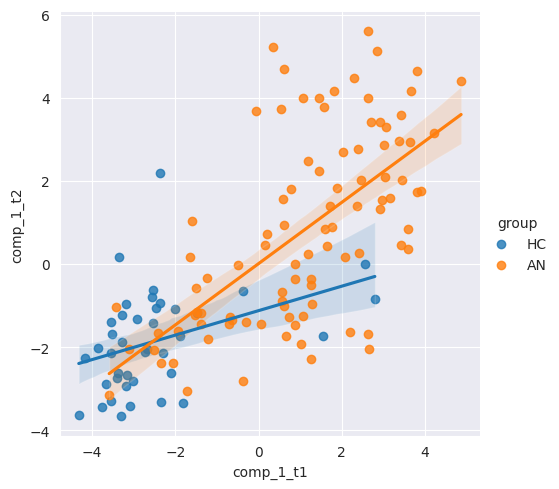

In [ ]:
sns.lmplot(x='comp_1_t1', y='comp_1_t2', hue='group', data=pca_df)